In [14]:
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='6d4d3c0a-aafd-4cdf-a76f-681953d88529', project_access_token='p-49c49ca14958bc2075cf37302d2d57e31d20674d')
pc = project.project_context


# Best Neighborhood in Toronto to Open Italian Restaurants

## ----------- Get Toronto Neighborhoods Info -----------

In [2]:
import pandas as pd

### Get all tables from the website

In [3]:
raw_data = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

### The 1st table is the one we need

In [4]:
postal_codes = raw_data[0]

### Create an empty dataframe with column names

In [5]:
column_names = ['PostalCode', 'Borough', 'Neighborhood'] 
neighborhoods = pd.DataFrame(columns=column_names)

### Parse each cell in the table

In [6]:
for index, row in postal_codes.iterrows():
    for cell in row:
        # Discard those having "Not assigned" for Borough
        if not("Not assigned" in cell):
            # The first 3 characters are the postal codes
            postal_code = cell[0:3]
            neighborhood_begin = cell.find('(')
            if neighborhood_begin == -1:
                # No '()' in the current cell, so no neighborhood for the current borough
                neighborhood_begin = len(cell)
            borough = cell[3:neighborhood_begin]
            neighborhood = ''
            if neighborhood_begin == len(cell):
                # No neighborhood for the current borough, use borough name for neighborhood
                neighborhood = borough
            else:
                neighborhood_end = cell.find(')')
                # For neighborhoods string, replace " /" with ","
                neighborhood = cell[neighborhood_begin + 1 : neighborhood_end].replace(' /', ',')
            neighborhoods = neighborhoods.append({'PostalCode': postal_code, 'Borough': borough, 'Neighborhood': neighborhood}, ignore_index=True)

### The borough and neighborhood table for Toronto

In [7]:
neighborhoods.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [8]:
neighborhoods.shape

(103, 3)

## ------- Get Geospatial Data for Each Neighborhood -------

## Load Geospatial Data

In [9]:
!wget -q -O 'geospatial_data.csv' http://cocl.us/Geospatial_data
print('Geospatial Data downloaded!')

Geospatial Data downloaded!


In [10]:
import csv

## Build Geospatial Data Dictionary and Append Corresponding Latitude and Longitude to Neighborhoods Table

In [11]:
geo_dict = dict()
with open('geospatial_data.csv') as g_data:
    reader = csv.reader(g_data)
    for row in reader:
        geo_dict[row[0]]=(row[1], row[2])

In [12]:
latitude = []
longitude = []
for index, row in neighborhoods.iterrows():
    latitude.append(geo_dict[row['PostalCode']][0])
    longitude.append(geo_dict[row['PostalCode']][1])
neighborhoods['Latitude'] = latitude
neighborhoods['Longitude'] = longitude

In [13]:
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7532586,-79.3296565
1,M4A,North York,Victoria Village,43.7258823,-79.3155716
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6542599,-79.3606359
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.4647633
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6623015,-79.3894938


In [15]:
project.save_data("neighborhoods.csv", neighborhoods.to_csv())

{'file_name': 'neighborhoods.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'applieddatasciencecapstone-donotdelete-pr-zftegopqhlzqof',
 'asset_id': 'a0f5af07-a951-4de2-8e47-f7b5c0a4fec4'}

In [18]:
neighborhoods_file = project.get_file("neighborhoods.csv")
neighborhoods_file.seek(0)
neighborhoods_copy = pd.read_csv(neighborhoods_file, index_col=0)
neighborhoods_copy.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## --------------- Draw the Neighborhoods Map ----------------

In [19]:
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes
from geopy.geocoders import Nominatim
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1e             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1

## Use Lawrence Park as the center of the map, as it looks like the center of the data we have.

In [20]:
address = 'Lawrence Park, Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
toronto_latitude = location.latitude
toronto_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(toronto_latitude, toronto_longitude))

The geograpical coordinate of Toronto are 43.729199, -79.4032525.


In [21]:
neighborhoods['Latitude'] = neighborhoods['Latitude'].astype('float32')
neighborhoods['Longitude'] = neighborhoods['Longitude'].astype('float32')

In [22]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Define Foursquare Credentials and other pass-in parameters

In [23]:
CLIENT_ID = '4ASKEIB5I2KXBAECJ4YVHIJTFOZ3NQUXHDFRCSF42RTCQ5IC'
CLIENT_SECRET = 'PNLW2FDRBJEAM4AUXHVF3LIV02SMUBUSTOBNDUDFU31FZ5R4'
VERSION = '20180605'
SECTION = 'food'
LIMIT = 50
import json
import requests

## Define the function to get restaurants information, including categories, likes, etc.

In [24]:
  def getNearbyRestaurants(names, latitudes, longitudes, radius=2000):
    
    restaurants_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat, 
            lng, 
            radius, 
            LIMIT,
            SECTION)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        for result in results:
            venue_name = result['venue']['name']
            venue_main_category = result['venue']['categories'][0]['name']
            venue_id = result['venue']['id']
            url_likes = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
                venue_id,
                CLIENT_ID, 
                CLIENT_SECRET,
                VERSION)
            likes = requests.get(url_likes).json()["response"]['likes']['count']
            restaurants_list.append([(name, lat, lng, venue_name, venue_main_category, likes)])

    nearby_restaurants = pd.DataFrame([item for restaurant_list in restaurants_list for item in restaurant_list])
    nearby_restaurants.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Restaurant', 'Main Category', 'Likes']
    
    return(nearby_restaurants)

## --------- Get nearby restaurants for each neighborhood --------

In [25]:
toronto_restaurants = getNearbyRestaurants(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )
toronto_restaurants

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview
The Danforth Wes

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurant,Main Category,Likes
0,Parkwoods,43.753258,-79.329659,Allwyn's Bakery,Caribbean Restaurant,18
1,Parkwoods,43.753258,-79.329659,Darband Restaurant,Middle Eastern Restaurant,45
2,Parkwoods,43.753258,-79.329659,Me Va Me Kitchen Express,Mediterranean Restaurant,18
3,Parkwoods,43.753258,-79.329659,Tim Hortons,Café,7
4,Parkwoods,43.753258,-79.329659,The Captain's Boil,Seafood Restaurant,11
5,Parkwoods,43.753258,-79.329659,Island Foods,Caribbean Restaurant,23
6,Parkwoods,43.753258,-79.329659,Casa Manila,Asian Restaurant,43
7,Parkwoods,43.753258,-79.329659,Matsuda Japanese Cuisine & Teppanyaki,Japanese Restaurant,37
8,Parkwoods,43.753258,-79.329659,Gilaneh,Persian Restaurant,39
9,Parkwoods,43.753258,-79.329659,Baretto Caffé,Café,11


## Save the above result to the storage

In [26]:
project.save_data("toronto_restaurants.csv", toronto_restaurants.to_csv())

{'file_name': 'toronto_restaurants.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'applieddatasciencecapstone-donotdelete-pr-zftegopqhlzqof',
 'asset_id': '2c544bfb-0ccc-497c-989e-e128475be3b9'}

## How many unique categories can be curated from all the returned restaurants

In [27]:
print('There are {} uniques categories.'.format(len(toronto_restaurants['Main Category'].unique())))

There are 107 uniques categories.


## ------------- Get the top 10 categories -------------

In [29]:
top_10_categories = pd.Series(toronto_restaurants['Main Category']).value_counts(normalize=True)
top_10_categories.head(10)

Café                    0.075963
Pizza Place             0.072622
Restaurant              0.061929
Italian Restaurant      0.059701
Sandwich Place          0.052127
Bakery                  0.050791
Japanese Restaurant     0.040766
Fast Food Restaurant    0.032969
Sushi Restaurant        0.032078
Chinese Restaurant      0.030742
Name: Main Category, dtype: float64

## Convert the above table into a bar chart

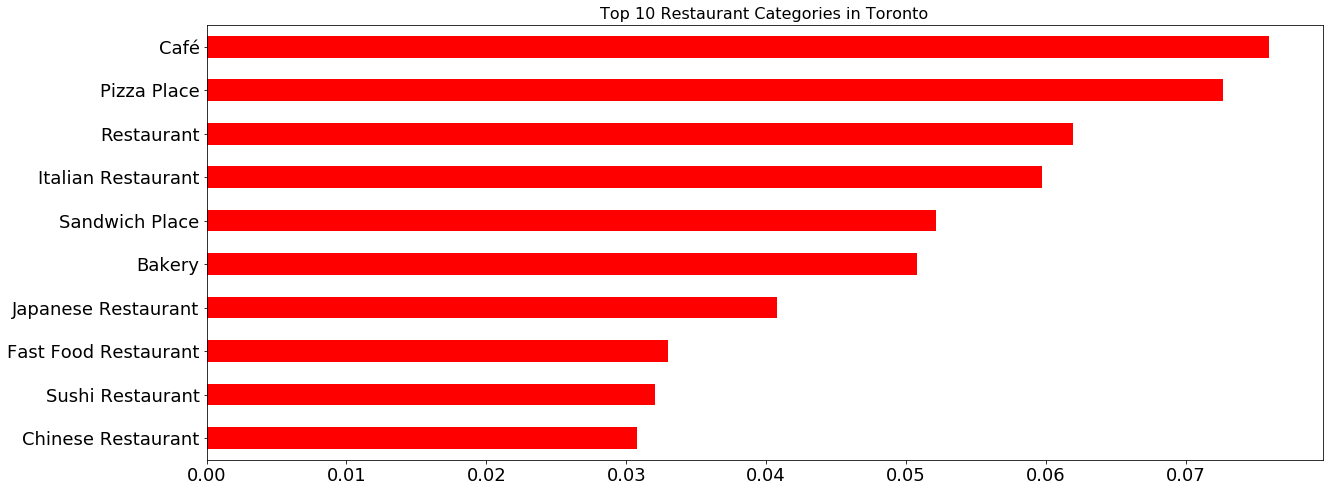

In [38]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
pd.Series(toronto_restaurants['Main Category']).value_counts(normalize=True, ascending=True).tail(10).plot(kind='barh', figsize=(20, 8), color="#FF0000", fontsize=18)
plt.title("Top 10 Restaurant Categories in Toronto", fontsize=16)
plt.show()

## ------------------- Only Keep Italian Restaurants -------------------

In [88]:
italian_restaurants = toronto_restaurants.loc[toronto_restaurants['Main Category'] == "Italian Restaurant"]
italian_restaurants

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurant,Main Category,Likes
15,Parkwoods,43.753258,-79.329659,Paisano,Italian Restaurant,6
83,Victoria Village,43.725883,-79.315575,La Famliglia,Italian Restaurant,3
97,"Regent Park, Harbourfront",43.654259,-79.360634,Mangia and Bevi Resto-Bar,Italian Restaurant,77
100,"Regent Park, Harbourfront",43.654259,-79.360634,Fusaro's,Italian Restaurant,57
121,"Regent Park, Harbourfront",43.654259,-79.360634,Terroni,Italian Restaurant,278
175,"Lawrence Manor, Lawrence Heights",43.718517,-79.464760,Vivo Pizza And Pasta,Italian Restaurant,5
177,"Lawrence Manor, Lawrence Heights",43.718517,-79.464760,Jamie's Italian,Italian Restaurant,74
184,"Lawrence Manor, Lawrence Heights",43.718517,-79.464760,Speducci,Italian Restaurant,9
185,"Lawrence Manor, Lawrence Heights",43.718517,-79.464760,Mastro's Ristorante,Italian Restaurant,2
195,"Queen's Park, Ontario Provincial Government",43.662300,-79.389496,Mercatto,Italian Restaurant,56


## Count the number of Italian Restaurants and total Likes received in each neighborhood

In [89]:
italian_dict = dict()
for index, row in italian_restaurants.iterrows():
    if not row['Neighborhood'] in italian_dict.keys():
        italian_dict[row['Neighborhood']] = dict()
        
    if not 'Neighborhood Latitude' in italian_dict[row['Neighborhood']].keys():
        italian_dict[row['Neighborhood']]['Neighborhood Latitude'] = row['Neighborhood Latitude']
        
    if not 'Neighborhood Longitude' in italian_dict[row['Neighborhood']].keys():
        italian_dict[row['Neighborhood']]['Neighborhood Longitude'] = row['Neighborhood Longitude']
    
    if not 'Count' in italian_dict[row['Neighborhood']].keys():
        italian_dict[row['Neighborhood']]['Count'] = 0
    italian_dict[row['Neighborhood']]['Count'] = italian_dict[row['Neighborhood']]['Count'] + 1
    
    if not 'Likes' in italian_dict[row['Neighborhood']].keys():
        italian_dict[row['Neighborhood']]['Likes'] = 0
    italian_dict[row['Neighborhood']]['Likes'] = italian_dict[row['Neighborhood']]['Likes'] + row['Likes']

italian_count_likes = pd.DataFrame.from_dict(italian_dict).transpose()
# italian_count_likes.reset_index(inplace=True)
# italian_count_likes.rename(columns={"index": "Neighborhood"}, inplace=True)
italian_count_likes['Count'] = italian_count_likes['Count'].astype(int)
italian_count_likes['Likes'] = italian_count_likes['Likes'].astype(int)
italian_count_likes.head()

,Count,Likes,Neighborhood Latitude,Neighborhood Longitude
Parkwoods,1,6,43.753258,-79.329659
Victoria Village,1,3,43.725883,-79.315575
"Regent Park, Harbourfront",3,412,43.654259,-79.360634
"Lawrence Manor, Lawrence Heights",4,90,43.718517,-79.464760
"Queen's Park, Ontario Provincial Government",4,440,43.662300,-79.389496


## ------------- Normalize the data -------------

In [90]:
count_total = italian_count_likes['Count'].sum()
print("Total Number of Italian Restaurants: " + str(count_total))
likes_total = italian_count_likes['Likes'].sum()
print("Total Likes Received for All Italian Restaurants: " + str(likes_total))

Total Number of Italian Restaurants: 268
Total Likes Received for All Italian Restaurants: 12954


In [91]:
italian_count_likes['Count'] = italian_count_likes['Count'].div(count_total)
italian_count_likes['Likes'] = italian_count_likes['Likes'].div(likes_total)

In [92]:
italian_count_likes.head()

,Count,Likes,Neighborhood Latitude,Neighborhood Longitude
Parkwoods,0.003731,0.000463,43.753258,-79.329659
Victoria Village,0.003731,0.000232,43.725883,-79.315575
"Regent Park, Harbourfront",0.011194,0.031805,43.654259,-79.360634
"Lawrence Manor, Lawrence Heights",0.014925,0.006948,43.718517,-79.464760
"Queen's Park, Ontario Provincial Government",0.014925,0.033966,43.662300,-79.389496


## Turn the data into a bar chart

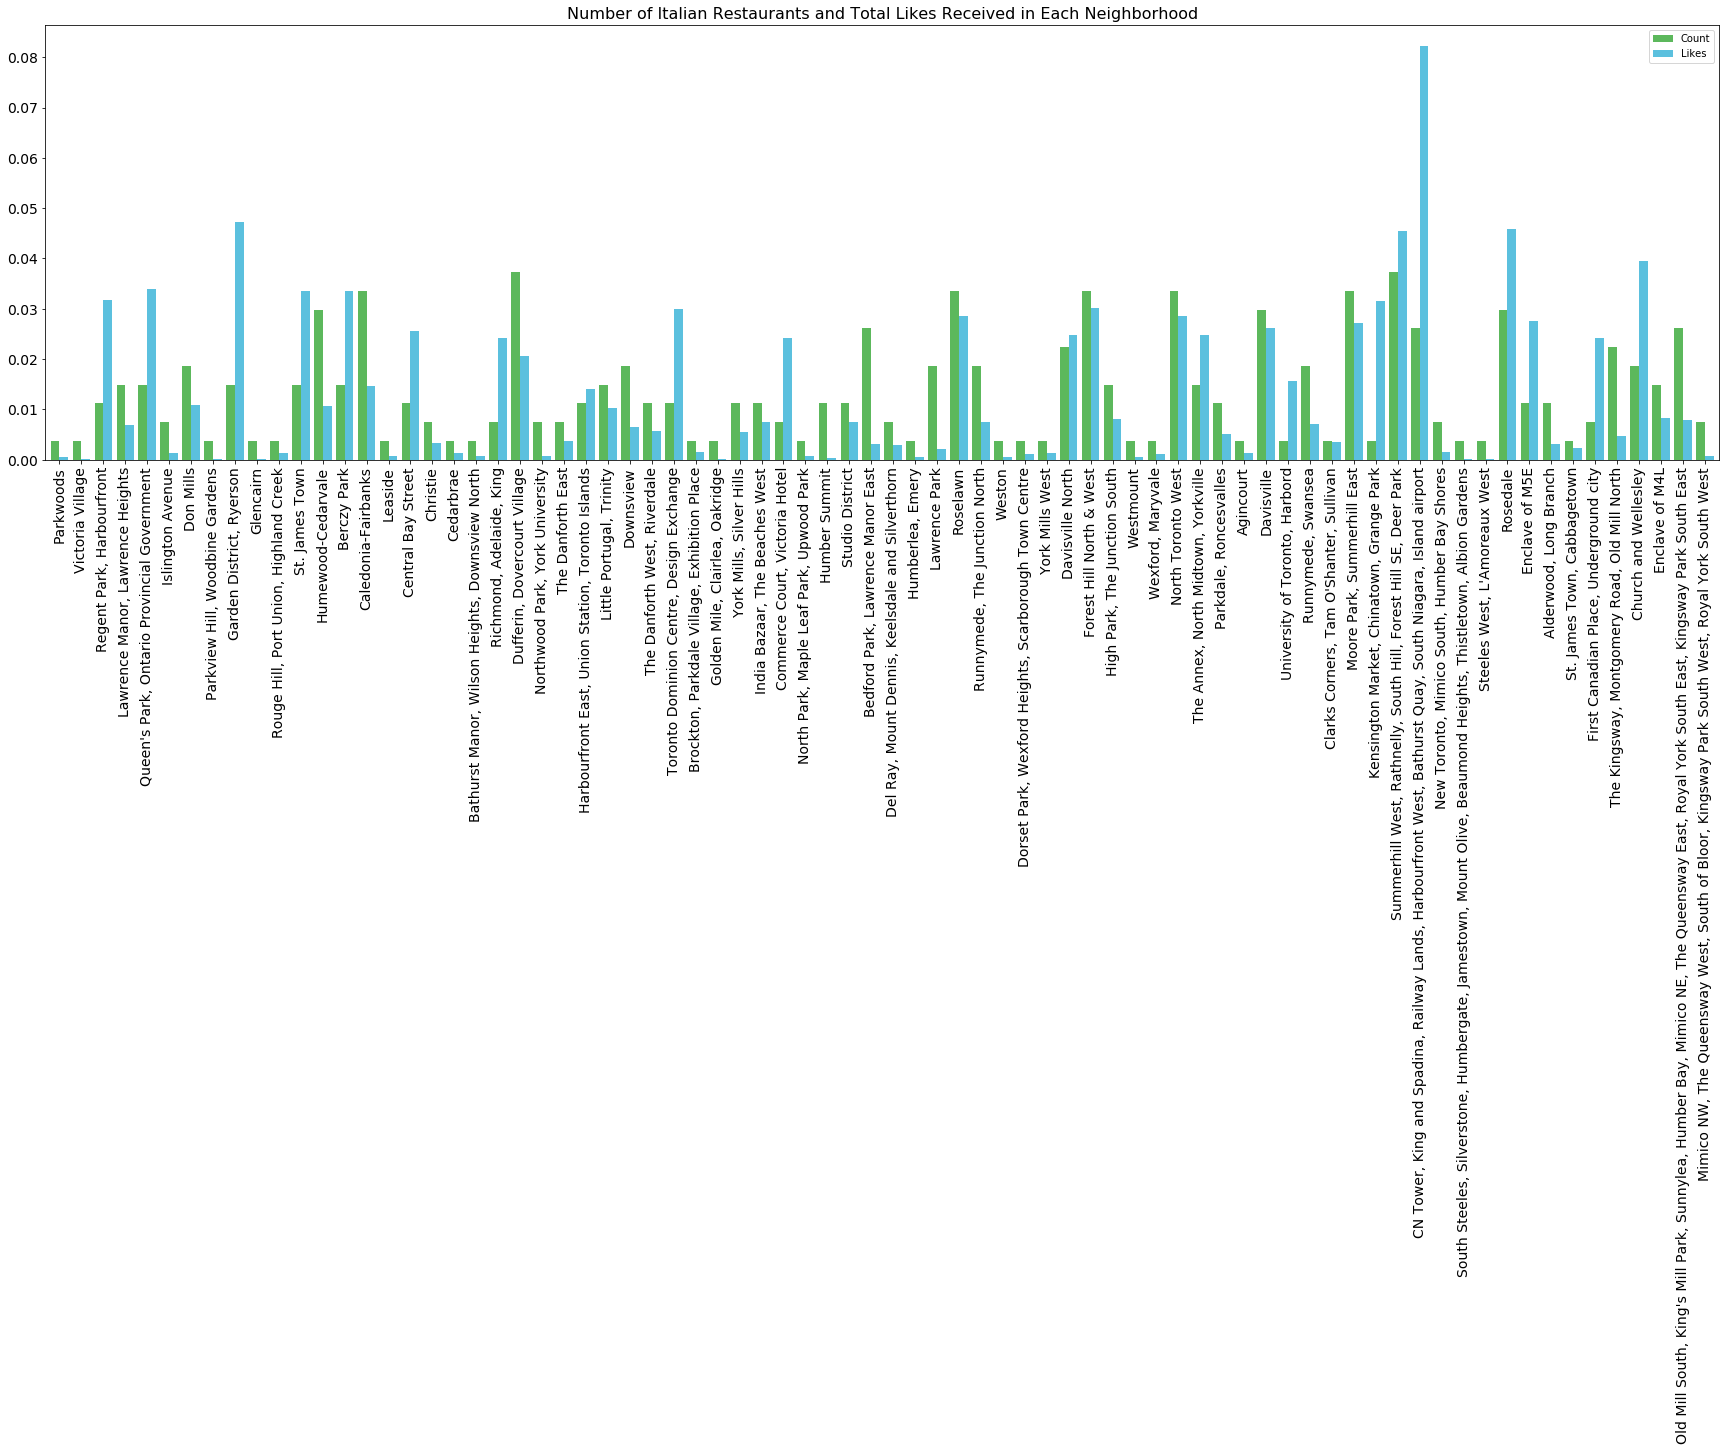

In [93]:
colors = ['#5cb85c','#5bc0de']
italian_count_likes[['Count','Likes']].plot(kind='bar', figsize=(30, 8), color=colors, width=0.8, fontsize=14)
plt.title("Number of Italian Restaurants and Total Likes Received in Each Neighborhood", fontsize=16)
plt.show()

## --------------- Cluster Neighborhoods ---------------

In [94]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

italian_count_likes_clustering = italian_count_likes.drop(['Neighborhood Latitude', 'Neighborhood Longitude'], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(italian_count_likes_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 4, 1, 0, 4, 0, 1, 0], dtype=int32)

## Insert the clustering labels into rows

In [95]:
# add clustering labels
italian_count_likes.insert(0, 'Cluster Label', kmeans.labels_)

In [102]:
italian_count_likes.head()

,Neighborhood,Cluster Label,Count,Likes,Neighborhood Latitude,Neighborhood Longitude
0,Parkwoods,0,0.003731,0.000463,43.753258,-79.329659
1,Victoria Village,0,0.003731,0.000232,43.725883,-79.315575
2,"Regent Park, Harbourfront",1,0.011194,0.031805,43.654259,-79.360634
3,"Lawrence Manor, Lawrence Heights",4,0.014925,0.006948,43.718517,-79.464760
4,"Queen's Park, Ontario Provincial Government",1,0.014925,0.033966,43.662300,-79.389496


## ---------- Visualize the resulting clusters ----------

In [97]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

italian_count_likes.dropna(subset = ["Cluster Label"], inplace=True)
italian_count_likes.reset_index(inplace=True)
italian_count_likes.rename(columns={"index": "Neighborhood"}, inplace=True)


In [99]:
italian_count_likes.head()

,Neighborhood,Cluster Label,Count,Likes,Neighborhood Latitude,Neighborhood Longitude
0,Parkwoods,0,0.003731,0.000463,43.753258,-79.329659
1,Victoria Village,0,0.003731,0.000232,43.725883,-79.315575
2,"Regent Park, Harbourfront",1,0.011194,0.031805,43.654259,-79.360634
3,"Lawrence Manor, Lawrence Heights",4,0.014925,0.006948,43.718517,-79.464760
4,"Queen's Park, Ontario Provincial Government",1,0.014925,0.033966,43.662300,-79.389496


In [103]:

# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(italian_count_likes['Neighborhood Latitude'], italian_count_likes['Neighborhood Longitude'], italian_count_likes['Neighborhood'], italian_count_likes['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Determine which group represents the best neighborhoods

In [106]:
italian_count_likes.loc[italian_count_likes['Cluster Label'] == 0].head()

,Neighborhood,Cluster Label,Count,Likes,Neighborhood Latitude,Neighborhood Longitude
0,Parkwoods,0,0.003731,0.000463,43.753258,-79.329659
1,Victoria Village,0,0.003731,0.000232,43.725883,-79.315575
5,Islington Avenue,0,0.007463,0.001312,43.667854,-79.532242
7,"Parkview Hill, Woodbine Gardens",0,0.003731,0.000232,43.706398,-79.309937
9,Glencairn,0,0.003731,0.000232,43.709576,-79.445076


In [107]:
italian_count_likes.loc[italian_count_likes['Cluster Label'] == 1].head()

,Neighborhood,Cluster Label,Count,Likes,Neighborhood Latitude,Neighborhood Longitude
2,"Regent Park, Harbourfront",1,0.011194,0.031805,43.654259,-79.360634
4,"Queen's Park, Ontario Provincial Government",1,0.014925,0.033966,43.662300,-79.389496
8,"Garden District, Ryerson",1,0.014925,0.047167,43.657162,-79.378937
11,St. James Town,1,0.014925,0.033503,43.651493,-79.375420
13,Berczy Park,1,0.014925,0.033503,43.644772,-79.373306


In [108]:
italian_count_likes.loc[italian_count_likes['Cluster Label'] == 2].head()

,Neighborhood,Cluster Label,Count,Likes,Neighborhood Latitude,Neighborhood Longitude
14,Caledonia-Fairbanks,2,0.033582,0.014590,43.689026,-79.453514
21,"Dufferin, Dovercourt Village",2,0.037313,0.020611,43.669006,-79.442261
41,Roselawn,2,0.033582,0.028485,43.711697,-79.416939
47,Forest Hill North & West,2,0.033582,0.030184,43.696949,-79.411308
51,North Toronto West,2,0.033582,0.028485,43.715382,-79.405678


In [109]:
italian_count_likes.loc[italian_count_likes['Cluster Label'] == 3].head()

,Neighborhood,Cluster Label,Count,Likes,Neighborhood Latitude,Neighborhood Longitude
62,"CN Tower, King and Spadina, Railway Lands, Har...",3,0.026119,0.082291,43.628948,-79.394417


In [110]:
italian_count_likes.loc[italian_count_likes['Cluster Label'] == 4].head()

,Neighborhood,Cluster Label,Count,Likes,Neighborhood Latitude,Neighborhood Longitude
3,"Lawrence Manor, Lawrence Heights",4,0.014925,0.006948,43.718517,-79.464760
6,Don Mills,4,0.018657,0.010807,43.745907,-79.352188
12,Humewood-Cedarvale,4,0.029851,0.010730,43.693783,-79.428192
24,"Harbourfront East, Union Station, Toronto Islands",4,0.011194,0.014127,43.640816,-79.381752
25,"Little Portugal, Trinity",4,0.014925,0.010344,43.647926,-79.419746


# Cluster 3 (CN Tower) won the contest!